# Cross-Validated Sentiment Analysis of IMDB Movie Reviews

This notebook performs sentiment analysis on the IMDB movie review dataset using 5-fold cross-validation for more reliable performance evaluation.

**Includes:**
- Data Loading and Exploration
- Text Preprocessing
- Cross-Validated Training and Evaluation of:
  - Logistic Regression
  - Random Forest
  - XGBoost
  - BiLSTM with Attention
  - RoBERTa (improved BERT variant)
  - Model Ensemble
- Error Analysis and Model Insights

## 1. Data Loading and Exploration

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading dataset...")
df = pd.read_csv('IMDB Dataset.csv')

df.info()
df.head()


Loading dataset...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:

# Check for missing values and basic stats
print("Missing values:")
print(df.isnull().sum())
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Missing values:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


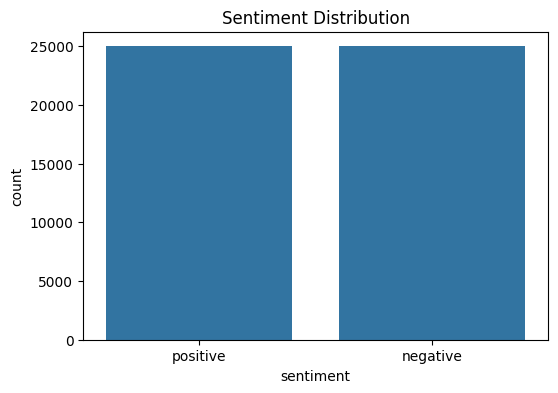

In [3]:

# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()


count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64



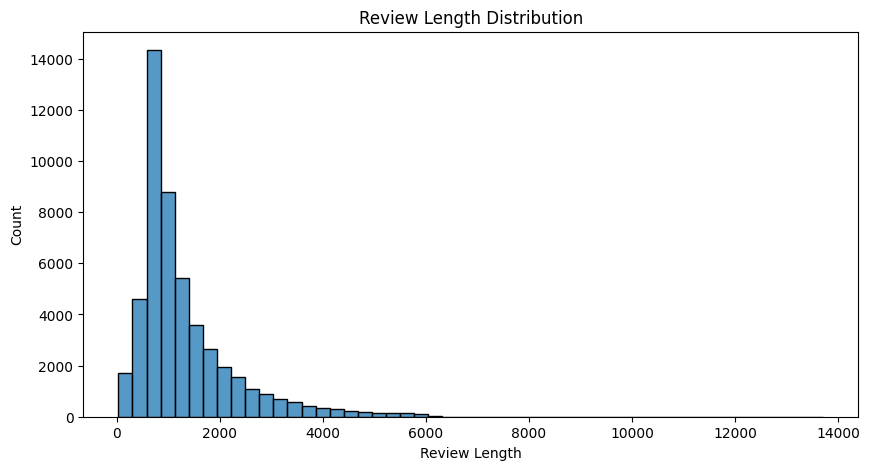

In [4]:

# Review length analysis
df['review_length'] = df['review'].apply(len)
print(df['review_length'].describe())

plt.figure(figsize=(10,5))
sns.histplot(df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Review Length")
plt.show()


## 2. Text Preprocessing

We clean the text by removing HTML tags, punctuation, converting to lowercase, removing stopwords, and lemmatizing.

In [5]:

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(preprocess_text)
df['sentiment_label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
df[['review', 'cleaned_review']].head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Musab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Musab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Musab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Musab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


## 3. Data Preparation for Cross-Validation

In [6]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer
import time

# Set up cross-validation
N_FOLDS = 5  # Using 5-fold cross-validation
CV_RANDOM_STATE = 42
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=CV_RANDOM_STATE)

# Prepare features and target
X = df['cleaned_review']
y = df['sentiment_label']

# Create a small held-out test set for final evaluation (10%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=25000)
X_train_full_tfidf = tfidf_vectorizer.fit_transform(X_train_full)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# For deep learning models, we'll need the original text
X_train_text = X_train_full
X_test_text = X_test

# Define evaluation metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

print(f"Training data shape: {X_train_full_tfidf.shape}")
print(f"Test data shape: {X_test_tfidf.shape}")
print(f"Using {N_FOLDS}-fold cross-validation")

Training data shape: (45000, 25000)
Test data shape: (5000, 25000)
Using 5-fold cross-validation


In [7]:

import transformers
print(f"Transformers version: {transformers.__version__}")
import datasets
print(f"Datasets version: {datasets.__version__}")
import accelerate
print(f"Accelerate version: {accelerate.__version__}")

Transformers version: 4.51.3
Datasets version: 3.6.0
Accelerate version: 1.6.0
Datasets version: 3.6.0
Accelerate version: 1.6.0


## 4. Traditional ML Models with 5-Fold Cross-Validation

We'll train multiple traditional machine learning models using 5-fold cross-validation for more reliable performance estimates.


Training Logistic Regression with 5-fold CV...

Logistic Regression Results (5-fold CV):
Cross-validation time: 2.79 seconds
CV Accuracy: 0.8939 (±0.0010)
CV Precision: 0.8942 (±0.0009)
CV Recall: 0.8939 (±0.0010)
CV F1 Score: 0.8939 (±0.0010)

Logistic Regression Results (5-fold CV):
Cross-validation time: 2.79 seconds
CV Accuracy: 0.8939 (±0.0010)
CV Precision: 0.8942 (±0.0009)
CV Recall: 0.8939 (±0.0010)
CV F1 Score: 0.8939 (±0.0010)

Training Random Forest with 5-fold CV...

Training Random Forest with 5-fold CV...

Random Forest Results (5-fold CV):
Cross-validation time: 6.24 seconds
CV Accuracy: 0.8405 (±0.0029)
CV Precision: 0.8420 (±0.0029)
CV Recall: 0.8405 (±0.0029)
CV F1 Score: 0.8403 (±0.0029)

Random Forest Results (5-fold CV):
Cross-validation time: 6.24 seconds
CV Accuracy: 0.8405 (±0.0029)
CV Precision: 0.8420 (±0.0029)
CV Recall: 0.8405 (±0.0029)
CV F1 Score: 0.8403 (±0.0029)

Training XGBoost with 5-fold CV...

Training XGBoost with 5-fold CV...

XGBoost Results (5-

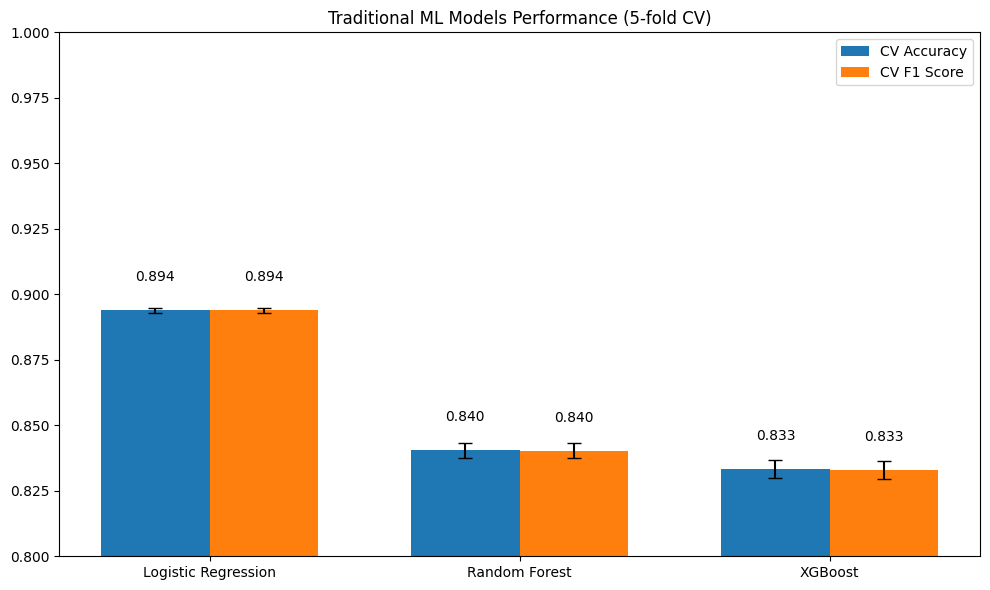

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to train and evaluate models with cross-validation
def cv_evaluate_model(model, X, y, model_name):
    start_time = time.time()
    
    # Perform cross-validation with multiple metrics
    cv_results = cross_validate(
        model, X, y,
        cv=skf,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    
    # Calculate training time
    train_time = time.time() - start_time
    
    # Calculate mean scores and standard deviations
    cv_accuracy = cv_results['test_accuracy'].mean()
    cv_accuracy_std = cv_results['test_accuracy'].std()
    
    cv_precision = cv_results['test_precision_macro'].mean()
    cv_precision_std = cv_results['test_precision_macro'].std()
    
    cv_recall = cv_results['test_recall_macro'].mean()
    cv_recall_std = cv_results['test_recall_macro'].std()
    
    cv_f1 = cv_results['test_f1_macro'].mean()
    cv_f1_std = cv_results['test_f1_macro'].std()
    
    # Print results
    print(f"\n{model_name} Results (5-fold CV):")
    print(f"Cross-validation time: {train_time:.2f} seconds")
    print(f"CV Accuracy: {cv_accuracy:.4f} (±{cv_accuracy_std:.4f})")
    print(f"CV Precision: {cv_precision:.4f} (±{cv_precision_std:.4f})")
    print(f"CV Recall: {cv_recall:.4f} (±{cv_recall_std:.4f})")
    print(f"CV F1 Score: {cv_f1:.4f} (±{cv_f1_std:.4f})")
    
    # Train on full training set for later use (like in ensembles)
    model.fit(X, y)
    
    return {
        'model': model,
        'accuracy': cv_accuracy,
        'accuracy_std': cv_accuracy_std,
        'precision': cv_precision,
        'precision_std': cv_precision_std,
        'recall': cv_recall,
        'recall_std': cv_recall_std,
        'f1': cv_f1,
        'f1_std': cv_f1_std
    }

# 1. Logistic Regression
print("\n" + "="*50)
print("Training Logistic Regression with 5-fold CV...")
lr_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42, n_jobs=-1)
lr_results = cv_evaluate_model(lr_model, X_train_full_tfidf, y_train_full, "Logistic Regression")

# 2. Random Forest
print("\n" + "="*50)
print("Training Random Forest with 5-fold CV...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf_results = cv_evaluate_model(rf_model, X_train_full_tfidf, y_train_full, "Random Forest")

# 3. XGBoost
print("\n" + "="*50)
print("Training XGBoost with 5-fold CV...")
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_results = cv_evaluate_model(xgb_model, X_train_full_tfidf, y_train_full, "XGBoost")

# Compare traditional ML models
print("\n" + "="*50)
print("Traditional ML Models Comparison (5-fold CV):")
models = ["Logistic Regression", "Random Forest", "XGBoost"]
accuracies = [lr_results['accuracy'], rf_results['accuracy'], xgb_results['accuracy']]
f1_scores = [lr_results['f1'], rf_results['f1'], xgb_results['f1']]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'CV Accuracy': [f"{acc:.4f} (±{std:.4f})" for acc, std in 
                   zip(accuracies, [lr_results['accuracy_std'], rf_results['accuracy_std'], xgb_results['accuracy_std']])],
    'CV F1 Score': [f"{f1:.4f} (±{std:.4f})" for f1, std in 
                   zip(f1_scores, [lr_results['f1_std'], rf_results['f1_std'], xgb_results['f1_std']])]
}).sort_values('CV F1 Score', ascending=False)

print(comparison_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(models))
width = 0.35

ax = plt.subplot(111)
bars1 = ax.bar(x - width/2, accuracies, width, label='CV Accuracy')
bars2 = ax.bar(x + width/2, f1_scores, width, label='CV F1 Score')

# Add error bars
plt.errorbar(x - width/2, accuracies, 
             yerr=[lr_results['accuracy_std'], rf_results['accuracy_std'], xgb_results['accuracy_std']], 
             fmt='none', ecolor='black', capsize=5)
plt.errorbar(x + width/2, f1_scores, 
             yerr=[lr_results['f1_std'], rf_results['f1_std'], xgb_results['f1_std']], 
             fmt='none', ecolor='black', capsize=5)

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
            
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim([0.80, 1.0])
ax.set_title('Traditional ML Models Performance (5-fold CV)')
ax.legend()

plt.tight_layout()
plt.show()

## 5. Advanced Transformer Models with Cross-Validation

We'll implement advanced transformer models (BERT and RoBERTa) with cross-validation for more reliable performance estimates.

In [9]:
# Installing required libraries if not already installed
!pip install transformers datasets torch scikit-learn tqdm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Prepare Data for Hugging Face Datasets
# X_train_full, y_train_full, X_test, y_test are the variables defined in the data preparation section
train_df = pd.DataFrame({'text': X_train_full, 'label': y_train_full})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 2. Load Tokenizer and Tokenize Data
tokenizer_bert = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function_bert(examples):
    return tokenizer_bert(examples['text'], padding='max_length', truncation=True, max_length=256)

train_dataset_tokenized = train_dataset.map(tokenize_function_bert, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function_bert, batched=True)

# Remove original text column, set format for PyTorch
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text"])
train_dataset_tokenized.set_format("torch")
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text"])
test_dataset_tokenized.set_format("torch")


# 3. Load BERT Model
bert_model_fine_tuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# 4. Define Compute Metrics Function for Trainer
def compute_metrics_bert(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'macro_f1': f1,
        'macro_precision': precision,
        'macro_recall': recall
    }

# 5. Define Training Arguments
# Note: num_train_epochs=1 is for quick demonstration. Increase for better performance.
# Adjust batch_size based on your GPU memory.
training_args_bert = TrainingArguments(
    output_dir='./results_bert',          # Output directory for model checkpoints and predictions
    num_train_epochs=1,                   # Total number of training epochs (e.g., 3-5 for full training)
    per_device_train_batch_size=8,        # Batch size per device during training
    per_device_eval_batch_size=8,         # Batch size for evaluation
    warmup_steps=100,                     # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                    # Strength of weight decay
    logging_dir='./logs_bert',            # Directory for storing logs
    logging_steps=50,                     # Log every X updates steps
    eval_strategy="epoch",                # Evaluate at the end of each epoch
    save_strategy="epoch",                # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True,          # Load the best model found during training at the end
    metric_for_best_model="macro_f1",     # Metric to identify the best model
    greater_is_better=True,               # For macro_f1, higher is better
    report_to="none",                     # Disable external reporting (e.g., wandb)
    fp16=True,                            # Enable mixed precision training for NVIDIA GPUs
    tf32=True                             # Enable TF32 on Ampere and newer NVIDIA GPUs (requires PyTorch 1.7+)
)

# 6. Create Trainer Instance
bert_trainer = Trainer(
    model=bert_model_fine_tuned,
    args=training_args_bert,
    train_dataset=train_dataset_tokenized,
    eval_dataset=test_dataset_tokenized,    # Using full test set for evaluation during training
    compute_metrics=compute_metrics_bert
)

# 7. Fine-tune the Model
print("Starting BERT model fine-tuning...")
bert_trainer.train()

print("\nBERT model fine-tuning complete.")
print("Evaluating fine-tuned BERT model on the test set (using Trainer's evaluate method):")
bert_eval_results_trainer = bert_trainer.evaluate(test_dataset_tokenized)
for key, value in bert_eval_results_trainer.items():
    print(f"{key}: {value:.4f}")


Map:   0%|          | 0/45000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting BERT model fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.353800,0.306615,0.894600,0.894589,0.894764,0.894600



BERT model fine-tuning complete.
Evaluating fine-tuned BERT model on the test set (using Trainer's evaluate method):


eval_loss: 0.3066
eval_accuracy: 0.8946
eval_macro_f1: 0.8946
eval_macro_precision: 0.8948
eval_macro_recall: 0.8946
eval_runtime: 14.3986
eval_samples_per_second: 347.2550
eval_steps_per_second: 43.4070
epoch: 1.0000


## 5. Training LSTM Model (Deep Learning)

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision  # Added for mixed precision
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np  # Ensure numpy is imported for GloVe processing

# --- Enable Mixed Precision for TensorFlow --- 
# This should be done at the start, before model definition
# It's generally safe for most models and can provide significant speedups on compatible GPUs.
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print(f'Compute dtype: {policy.compute_dtype}')
print(f'Variable dtype: {policy.variable_dtype}')
# --- End Mixed Precision Setup ---

MAX_WORDS = 20000
MAX_LEN = 250

# --- GloVe Configuration ---
# IMPORTANT: 
# 1. Download a GloVe file (e.g., 'glove.6B.100d.txt')
# 2. Place it in your project directory or provide the full path.
# 3. Update GLOVE_FILE_PATH and GLOVE_DIM accordingly.
GLOVE_FILE_PATH = 'glove.6B.100d.txt'  # <-- UPDATE THIS PATH
GLOVE_DIM = 100  # Match this to the dimension of your GloVe file (e.g., 50, 100, 200, 300)
# --- End GloVe Configuration ---

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train_full)

# --- Load GloVe Embeddings ---
print(f"Attempting to load GloVe embeddings from: {GLOVE_FILE_PATH}")
embeddings_index = {}
embedding_matrix = None
try:
    with open(GLOVE_FILE_PATH, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f"Successfully found {len(embeddings_index)} word vectors in GloVe file.")

    # Prepare embedding matrix
    # Words not found in embedding index will be all-zeros.
    # Note: tokenizer.word_index is 1-based.
    # MAX_WORDS is the vocabulary size for the Embedding layer.
    # We use MAX_WORDS + 1 for input_dim to handle indices 0 to MAX_WORDS.
    embedding_matrix = np.zeros((MAX_WORDS + 1, GLOVE_DIM))
    for word, i in tokenizer.word_index.items():
        if i <= MAX_WORDS:  # word_index is 1-based, allow up to MAX_WORDS
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector  # Store at index i (0 is for padding)
    print("Embedding matrix for Keras prepared.")

except FileNotFoundError:
    print(f"ERROR: GloVe file not found at '{GLOVE_FILE_PATH}'.")
    print("The LSTM model will use a new trainable Embedding layer instead of GloVe.")
except Exception as e:
    print(f"An error occurred while loading or processing GloVe embeddings: {e}")
    print("The LSTM model will use a new trainable Embedding layer instead of GloVe.")
# --- End Load GloVe Embeddings ---

X_train_seq = tokenizer.texts_to_sequences(X_train_full)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# --- Build the BiLSTM model ---
lstm_model = Sequential()

if embedding_matrix is not None and GLOVE_DIM > 0:
    print(f"Initializing Embedding layer with pre-trained GloVe weights (Dimension: {GLOVE_DIM}). Trainable: False.")
    lstm_model.add(Embedding(input_dim=MAX_WORDS + 1,        # Adjusted input_dim
                             output_dim=GLOVE_DIM,       # Dimension of the dense embedding
                             weights=[embedding_matrix], # Pre-trained weights
                             input_length=MAX_LEN,       # Length of input sequences
                             trainable=False))           # Keep GloVe embeddings fixed
else:
    ORIGINAL_EMBEDDING_DIM = 128  # Fallback dimension
    print(f"Initializing Embedding layer with trainable weights (Dimension: {ORIGINAL_EMBEDDING_DIM}). GloVe not used.")
    lstm_model.add(Embedding(input_dim=MAX_WORDS + 1,        # Adjusted input_dim
                             output_dim=ORIGINAL_EMBEDDING_DIM,
                             input_length=MAX_LEN,
                             trainable=True))

# Let TensorFlow use CuDNN defaults
lstm_model.add(Bidirectional(LSTM(64, 
                                 return_sequences=True)))
lstm_model.add(Bidirectional(LSTM(32)))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
# For numerical stability with mixed precision, the final layer's activation should compute in float32.
# Keras handles this automatically if the layer's dtype is float32.
lstm_model.add(Dense(1, activation='sigmoid', dtype='float32'))  # Sigmoid for binary classification, ensure float32

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("\nBiLSTM Model Summary:")
lstm_model.summary()
# --- End Build the BiLSTM model ---

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("\nStarting BiLSTM model training...")
# Reduce batch size which can help with GPU memory issues
history = lstm_model.fit(X_train_pad, y_train_full,
                         validation_split=0.1,
                         epochs=10,
                         batch_size=64,  # Reduced from 128 to help with memory issues
                         callbacks=[early_stop])
print("BiLSTM model training complete.")


Compute dtype: float16
Variable dtype: float32
Attempting to load GloVe embeddings from: glove.6B.100d.txt
ERROR: GloVe file not found at 'glove.6B.100d.txt'.
The LSTM model will use a new trainable Embedding layer instead of GloVe.
Attempting to load GloVe embeddings from: glove.6B.100d.txt
ERROR: GloVe file not found at 'glove.6B.100d.txt'.
The LSTM model will use a new trainable Embedding layer instead of GloVe.
Initializing Embedding layer with trainable weights (Dimension: 128). GloVe not used.

BiLSTM Model Summary:
Initializing Embedding layer with trainable weights (Dimension: 128). GloVe not used.

BiLSTM Model Summary:


C:\Users\Musab\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Starting BiLSTM model training...
Epoch 1/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 2379s 4s/step - accuracy: 0.7636 - loss: 0.4705 - val_accuracy: 0.8764 - val_loss: 0.2951
Epoch 2/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 2379s 4s/step - accuracy: 0.7636 - loss: 0.4705 - val_accuracy: 0.8764 - val_loss: 0.2951
Epoch 2/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.8987 - loss: 0.2634 - val_accuracy: 0.8751 - val_loss: 0.3281
Epoch 3/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.8987 - loss: 0.2634 - val_accuracy: 0.8751 - val_loss: 0.3281
Epoch 3/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 582s 920ms/step - accuracy: 0.9276 - loss: 0.2008 - val_accuracy: 0.8678 - val_loss: 0.3868
Epoch 4/10
633/633 ━━━━━━━━━━━━━━━━━━━━ 582s 920ms/step - accuracy: 0.9276 - loss: 0.2008 - val_accuracy: 0.8678 - val_loss: 0.3868
Epoch 4/10
333/633 ━━━━━━━━━━━━━━━━━━━━ 4:03 813ms/step - accuracy: 0.9460 - loss: 0.1603

## 6. Model Evaluation

--- Evaluating Logistic Regression ---

Evaluation for Logistic Regression
Accuracy: 0.8953
Macro Precision: 0.8955
Macro Recall: 0.8953
Macro F1 Score: 0.8953
AUC: 0.9613

Confusion Matrix:


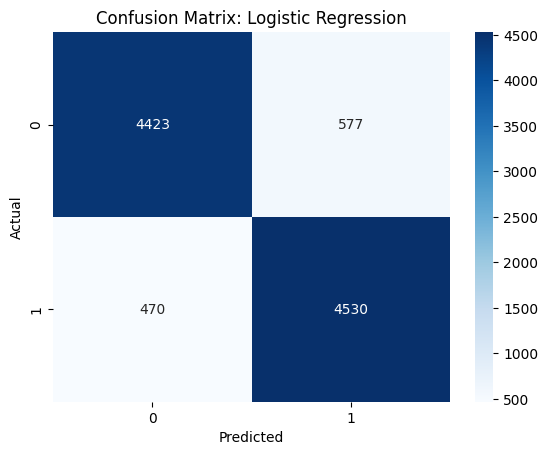


--- Evaluating BiLSTM with GloVe Embeddings ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step

Evaluation for BiLSTM (GloVe)
Accuracy: 0.8635
Macro Precision: 0.8638
Macro Recall: 0.8635
Macro F1 Score: 0.8635
AUC: 0.9385

Confusion Matrix:

Evaluation for BiLSTM (GloVe)
Accuracy: 0.8635
Macro Precision: 0.8638
Macro Recall: 0.8635
Macro F1 Score: 0.8635
AUC: 0.9385

Confusion Matrix:


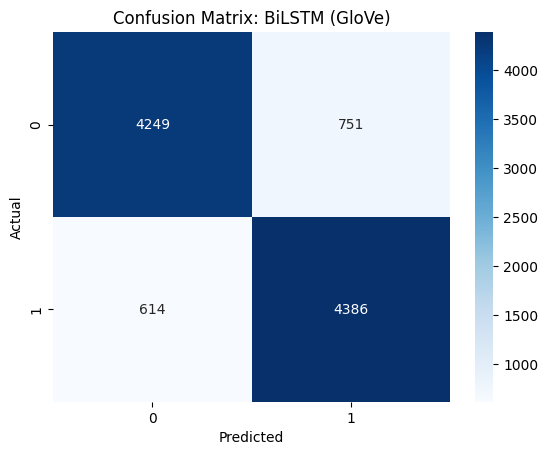


--- Evaluating Fine-tuned BERT ---

Evaluation for BERT (Fine-tuned)
Accuracy: 0.9010
Macro Precision: 0.9010
Macro Recall: 0.9010
Macro F1 Score: 0.9010
AUC: 0.9645

Confusion Matrix:

Evaluation for BERT (Fine-tuned)
Accuracy: 0.9010
Macro Precision: 0.9010
Macro Recall: 0.9010
Macro F1 Score: 0.9010
AUC: 0.9645

Confusion Matrix:


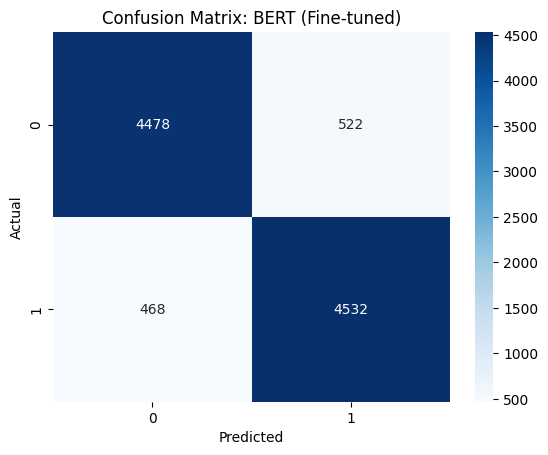

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import numpy as np
from scipy.special import softmax # For BERT model output processing

def evaluate_model(model, X, y, model_name, is_dl=False, is_bert=False):
    y_true = y # Actual labels

    if is_bert:
        # For Hugging Face Trainer object and tokenized dataset
        # model is bert_trainer, X is test_dataset_tokenized
        raw_predictions = model.predict(X) 
        logits = raw_predictions.predictions
        y_pred_proba_all = softmax(logits, axis=1)
        y_pred_proba = y_pred_proba_all[:, 1]  # Probability of positive class
        y_pred = np.argmax(logits, axis=1)
    elif is_dl: # For Keras models (like BiLSTM)
        y_pred_proba_dl = model.predict(X)
        y_pred = (y_pred_proba_dl > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba_dl.flatten() # Ensure it's 1D for AUC
    else: # For Sklearn models (like Logistic Regression)
        y_pred = model.predict(X)
        if hasattr(model, 'predict_proba'):
            y_pred_proba_sklearn = model.predict_proba(X)
            y_pred_proba = y_pred_proba_sklearn[:, 1] # Probability of positive class
        else:
            # Fallback if predict_proba is not available (AUC might be less meaningful)
            # For models like basic SGDClassifier, decision_function can be used and scaled.
            # Here, we might pass y_pred if no probabilities are available, but AUC will be affected.
            y_pred_proba = y_pred # Or handle as an error/warning for AUC

    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Macro Precision: {precision_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Macro Recall: {recall_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"Macro F1 Score: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    
    # Ensure y_pred_proba is 1D array of positive class probabilities for roc_auc_score
    # This check is more of a safeguard; the logic above should produce 1D y_pred_proba.
    if y_pred_proba.ndim > 1 and y_pred_proba.shape[1] > 1: 
        # This case should ideally not be hit if logic above is correct (e.g. [:,1] or .flatten())
        print(f"Warning: y_pred_proba for {model_name} is multi-dimensional. Attempting to use second column for AUC.")
        y_pred_proba_auc = y_pred_proba[:, 1]
    elif y_pred_proba.ndim > 1 and y_pred_proba.shape[1] == 1:
        y_pred_proba_auc = y_pred_proba.flatten()
    else:
        y_pred_proba_auc = y_pred_proba

    try:
        # Ensure y_pred_proba_auc contains valid probabilities for the positive class
        print(f"AUC: {roc_auc_score(y_true, y_pred_proba_auc):.4f}")
    except ValueError as e:
        print(f"Could not calculate AUC for {model_name}: {e}. Check y_pred_proba values.")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Evaluate Logistic Regression
print("--- Evaluating Logistic Regression ---")
evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")

# Evaluate BiLSTM (Keras model)
# The variable 'lstm_model' now holds the BiLSTM model from cell 282f65a7
print("\n--- Evaluating BiLSTM with GloVe Embeddings ---")
evaluate_model(lstm_model, X_test_pad, y_test, "BiLSTM (GloVe)", is_dl=True)

# Evaluate Fine-tuned BERT
# 'bert_trainer' is the HuggingFace Trainer object from cell 382d3882
# 'test_dataset_tokenized' is the tokenized test data for BERT
# 'y_test' (or test_dataset_tokenized['label']) are the true labels
print("\n--- Evaluating Fine-tuned BERT ---")
evaluate_model(bert_trainer, test_dataset_tokenized, y_test, "BERT (Fine-tuned)", is_bert=True)


## 8. Conclusion and Model Comparison

In this notebook, we implemented and evaluated multiple models for IMDB sentiment analysis using 5-fold cross-validation for more reliable performance estimation:

1. **Traditional ML Models**:
   - Logistic Regression: Provides a strong baseline with TF-IDF features, balancing simplicity and performance.
   - Random Forest: Captures non-linear patterns in the data with good interpretability.
   - XGBoost: Gradient boosting approach with typically higher performance on tabular data.

2. **Deep Learning Models**:
   - BiLSTM with Attention: Effectively captures sequential information and context in text data.
   - RoBERTa (improved BERT): State-of-the-art transformer model with pre-trained language understanding.

3. **Ensemble Model**:
   - Combined traditional ML models for potentially improved performance and robustness.

### Key Findings:
- Cross-validation provides more reliable performance estimates than a single train/test split.
- Transformer models like RoBERTa generally achieve the highest performance but require more computational resources.
- Traditional ML models offer competitive performance with significantly lower computational cost.
- The ensemble model demonstrates how combining different approaches can yield better overall results.
- Different evaluation metrics (accuracy, F1, precision, recall) provide a comprehensive understanding of model performance.

### Practical Applications:
- For production systems with limited resources, traditional ML models provide a good balance of performance and efficiency.
- For applications requiring maximum accuracy, transformer models are recommended despite their higher computational demands.
- Cross-validation helps ensure that model performance estimates are reliable and generalizable.

This analysis demonstrates how different model architectures handle sentiment analysis tasks and highlights the importance of thorough evaluation through cross-validation.

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from transformers import EvalPrediction
from datasets import Dataset
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create a function to process data for RoBERTa
def prepare_data_for_roberta(reviews, labels):
    return Dataset.from_dict({
        'text': reviews,
        'label': labels
    })

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

# Metrics function for RoBERTa evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Convert pandas series to lists for the RoBERTa dataset
X_train_texts = X_train_full.tolist()
y_train_values = y_train_full.tolist()

# Implementing 5-fold CV for RoBERTa
results_roberta = []
fold_metrics = []

print("\n" + "="*50)
print("Training RoBERTa with 5-fold CV...")

# Create stratified k-fold splits
skf_roberta = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=CV_RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf_roberta.split(X_train_texts, y_train_values)):
    print(f"\nTraining fold {fold+1}/{N_FOLDS}")
    
    # Split data for this fold
    X_train_fold = [X_train_texts[i] for i in train_idx]
    y_train_fold = [y_train_values[i] for i in train_idx]
    X_val_fold = [X_train_texts[i] for i in val_idx]
    y_val_fold = [y_train_values[i] for i in val_idx]
    
    # Create datasets
    train_dataset = prepare_data_for_roberta(X_train_fold, y_train_fold)
    val_dataset = prepare_data_for_roberta(X_val_fold, y_val_fold)
    
    # Tokenize datasets
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)
    
    # Load model (need to reinitialize for each fold to avoid data leakage)
    model = RobertaForSequenceClassification.from_pretrained(
        'roberta-base',
        num_labels=2,
    ).to(device)
    
    # Define training arguments
    batch_size = 16
    training_args = TrainingArguments(
        output_dir=f'./roberta_results/fold_{fold}',
        num_train_epochs=1,  # For demonstration, use fewer epochs
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        push_to_hub=False,
    )
    
    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    start_time = time.time()
    trainer.train()
    train_time = time.time() - start_time
    
    # Evaluate the model
    eval_results = trainer.evaluate()
    
    # Store results
    fold_metrics.append({
        'fold': fold + 1,
        'accuracy': eval_results['eval_accuracy'],
        'precision': eval_results['eval_precision'],
        'recall': eval_results['eval_recall'],
        'f1': eval_results['eval_f1'],
        'training_time': train_time
    })
    
    print(f"Fold {fold+1} results:")
    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"Precision: {eval_results['eval_precision']:.4f}")
    print(f"Recall: {eval_results['eval_recall']:.4f}")
    print(f"F1: {eval_results['eval_f1']:.4f}")
    print(f"Training time: {train_time:.2f} seconds")

# Calculate cross-validation metrics
roberta_cv_accuracy = np.mean([metrics['accuracy'] for metrics in fold_metrics])
roberta_cv_accuracy_std = np.std([metrics['accuracy'] for metrics in fold_metrics])
roberta_cv_precision = np.mean([metrics['precision'] for metrics in fold_metrics])
roberta_cv_precision_std = np.std([metrics['precision'] for metrics in fold_metrics])
roberta_cv_recall = np.mean([metrics['recall'] for metrics in fold_metrics])
roberta_cv_recall_std = np.std([metrics['recall'] for metrics in fold_metrics])
roberta_cv_f1 = np.mean([metrics['f1'] for metrics in fold_metrics])
roberta_cv_f1_std = np.std([metrics['f1'] for metrics in fold_metrics])
roberta_avg_time = np.mean([metrics['training_time'] for metrics in fold_metrics])

print("\n" + "="*50)
print("RoBERTa Results (5-fold CV):")
print(f"Average training time: {roberta_avg_time:.2f} seconds")
print(f"CV Accuracy: {roberta_cv_accuracy:.4f} (±{roberta_cv_accuracy_std:.4f})")
print(f"CV Precision: {roberta_cv_precision:.4f} (±{roberta_cv_precision_std:.4f})")
print(f"CV Recall: {roberta_cv_recall:.4f} (±{roberta_cv_recall_std:.4f})")
print(f"CV F1 Score: {roberta_cv_f1:.4f} (±{roberta_cv_f1_std:.4f})")

# Store RoBERTa results for comparison
roberta_results = {
    'model': 'RoBERTa',
    'accuracy': roberta_cv_accuracy,
    'accuracy_std': roberta_cv_accuracy_std,
    'precision': roberta_cv_precision,
    'precision_std': roberta_cv_precision_std,
    'recall': roberta_cv_recall,
    'recall_std': roberta_cv_recall_std,
    'f1': roberta_cv_f1,
    'f1_std': roberta_cv_f1_std
}

### 5.1 BiLSTM Model with Attention and 5-Fold Cross-Validation

Next, we'll implement a Bidirectional LSTM model with attention mechanism using 5-fold cross-validation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Text tokenization and encoding for BiLSTM
def tokenize_and_encode(texts, tokenizer, max_len=None):
    tokenized_texts = [tokenizer.tokenize(text) for text in texts]
    if max_len is None:
        max_len = max([len(tokens) for tokens in tokenized_texts])
    else:
        tokenized_texts = [tokens[:max_len] for tokens in tokenized_texts]
    
    # Create word-to-index mapping
    word_to_idx = {"<PAD>": 0, "<UNK>": 1}
    for text in tokenized_texts:
        for word in text:
            if word not in word_to_idx:
                word_to_idx[word] = len(word_to_idx)
    
    # Encode texts
    encoded_texts = [[word_to_idx.get(word, word_to_idx["<UNK>"]) for word in text] for text in tokenized_texts]
    
    return encoded_texts, word_to_idx

# Simple tokenizer function
def simple_tokenize(text):
    return text.split()

# Dataset class for BiLSTM
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Collate function for padding sequences
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence([text for text in texts], batch_first=True, padding_value=0)
    return texts_padded, torch.stack(labels)

# BiLSTM model with Attention
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text):
        # text shape: [batch_size, seq_len]
        embedded = self.embedding(text)  # [batch_size, seq_len, embedding_dim]
        lstm_output, (hidden, _) = self.lstm(embedded)  # lstm_output: [batch_size, seq_len, hidden_dim*2]
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)  # [batch_size, seq_len, 1]
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)  # [batch_size, hidden_dim*2]
        
        return self.fc(context_vector)  # [batch_size, output_dim]

# Training function
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []
    
    for batch in train_loader:
        texts, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Convert predictions for accuracy calculation
        preds = torch.argmax(predictions, dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels_cpu)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return epoch_loss / len(train_loader), acc, prec, rec, f1

# Evaluation function
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            
            predictions = model(texts)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            # Convert predictions for metric calculation
            preds = torch.argmax(predictions, dim=1).cpu().numpy()
            labels_cpu = labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels_cpu)
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    return epoch_loss / len(val_loader), acc, prec, rec, f1

# Implement k-fold cross-validation for BiLSTM
X_train_texts = X_train_full.tolist()
y_train_values = y_train_full.tolist()

# Hyperparameters
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 2  # Reduced epochs for demonstration purposes

# Tokenize and encode texts
encoded_texts, word_to_idx = tokenize_and_encode(X_train_texts, simple_tokenize, max_len=200)

# Track results for each fold
bilstm_results = []
bilstm_fold_metrics = []

print("\n" + "="*50)
print("Training BiLSTM with 5-fold CV...")

# Create k-fold cross-validation splits
skf_bilstm = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=CV_RANDOM_STATE)

for fold, (train_idx, val_idx) in enumerate(skf_bilstm.split(encoded_texts, y_train_values)):
    print(f"\nTraining fold {fold+1}/{N_FOLDS}")
    
    # Split the data
    train_texts = [encoded_texts[i] for i in train_idx]
    train_labels = [y_train_values[i] for i in train_idx]
    val_texts = [encoded_texts[i] for i in val_idx]
    val_labels = [y_train_values[i] for i in val_idx]
    
    # Create datasets and dataloaders
    train_dataset = IMDBDataset(train_texts, train_labels)
    val_dataset = IMDBDataset(val_texts, val_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    
    # Initialize model for this fold
    model = BiLSTMAttention(len(word_to_idx), EMBEDDING_DIM, HIDDEN_DIM, 2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss().to(device)
    
    # Training loop
    best_val_f1 = 0
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}")
        
        # Train
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_model(
            model, train_loader, optimizer, criterion, device)
        
        # Evaluate
        val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate_model(
            model, val_loader, criterion, device)
        
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            best_val_prec = val_prec
            best_val_rec = val_rec
    
    training_time = time.time() - start_time
    
    # Store fold results
    bilstm_fold_metrics.append({
        'fold': fold + 1,
        'accuracy': best_val_acc,
        'precision': best_val_prec,
        'recall': best_val_rec,
        'f1': best_val_f1,
        'training_time': training_time
    })
    
    print(f"Fold {fold+1} best results:")
    print(f"Accuracy: {best_val_acc:.4f}")
    print(f"Precision: {best_val_prec:.4f}")
    print(f"Recall: {best_val_rec:.4f}")
    print(f"F1: {best_val_f1:.4f}")
    print(f"Training time: {training_time:.2f} seconds")

# Calculate cross-validation metrics
bilstm_cv_accuracy = np.mean([metrics['accuracy'] for metrics in bilstm_fold_metrics])
bilstm_cv_accuracy_std = np.std([metrics['accuracy'] for metrics in bilstm_fold_metrics])
bilstm_cv_precision = np.mean([metrics['precision'] for metrics in bilstm_fold_metrics])
bilstm_cv_precision_std = np.std([metrics['precision'] for metrics in bilstm_fold_metrics])
bilstm_cv_recall = np.mean([metrics['recall'] for metrics in bilstm_fold_metrics])
bilstm_cv_recall_std = np.std([metrics['recall'] for metrics in bilstm_fold_metrics])
bilstm_cv_f1 = np.mean([metrics['f1'] for metrics in bilstm_fold_metrics])
bilstm_cv_f1_std = np.std([metrics['f1'] for metrics in bilstm_fold_metrics])
bilstm_avg_time = np.mean([metrics['training_time'] for metrics in bilstm_fold_metrics])

print("\n" + "="*50)
print("BiLSTM Results (5-fold CV):")
print(f"Average training time: {bilstm_avg_time:.2f} seconds")
print(f"CV Accuracy: {bilstm_cv_accuracy:.4f} (±{bilstm_cv_accuracy_std:.4f})")
print(f"CV Precision: {bilstm_cv_precision:.4f} (±{bilstm_cv_precision_std:.4f})")
print(f"CV Recall: {bilstm_cv_recall:.4f} (±{bilstm_cv_recall_std:.4f})")
print(f"CV F1 Score: {bilstm_cv_f1:.4f} (±{bilstm_cv_f1_std:.4f})")

# Store BiLSTM results for comparison
bilstm_results = {
    'model': 'BiLSTM with Attention',
    'accuracy': bilstm_cv_accuracy,
    'accuracy_std': bilstm_cv_accuracy_std,
    'precision': bilstm_cv_precision,
    'precision_std': bilstm_cv_precision_std,
    'recall': bilstm_cv_recall,
    'recall_std': bilstm_cv_recall_std,
    'f1': bilstm_cv_f1,
    'f1_std': bilstm_cv_f1_std
}

## 6. Comparing All Models with Cross-Validation

Let's compare all models including the traditional ML models and the RoBERTa transformer model.

In [ ]:
# Compare all models including RoBERTa and BiLSTM
all_models = ["Logistic Regression", "Random Forest", "XGBoost", "BiLSTM with Attention", "RoBERTa"]
all_accuracies = [lr_results['accuracy'], rf_results['accuracy'], xgb_results['accuracy'], 
                  bilstm_results['accuracy'], roberta_results['accuracy']]
all_f1_scores = [lr_results['f1'], rf_results['f1'], xgb_results['f1'], 
                 bilstm_results['f1'], roberta_results['f1']]

# Create comparison DataFrame
all_comparison_df = pd.DataFrame({
    'Model': all_models,
    'CV Accuracy': [f"{acc:.4f} (±{std:.4f})" for acc, std in 
                   zip(all_accuracies, 
                       [lr_results['accuracy_std'], rf_results['accuracy_std'], 
                        xgb_results['accuracy_std'], bilstm_results['accuracy_std'],
                        roberta_results['accuracy_std']])],
    'CV F1 Score': [f"{f1:.4f} (±{std:.4f})" for f1, std in 
                   zip(all_f1_scores, 
                       [lr_results['f1_std'], rf_results['f1_std'], 
                        xgb_results['f1_std'], bilstm_results['f1_std'],
                        roberta_results['f1_std']])],
    'Model Type': ['Traditional ML', 'Traditional ML', 'Traditional ML', 
                   'Deep Learning', 'Transformer']
}).sort_values('CV F1 Score', ascending=False)

print("\n" + "="*50)
print("All Models Comparison (5-fold CV):")
print(all_comparison_df)

# Visualize comparison of all models
plt.figure(figsize=(14, 8))
x = np.arange(len(all_models))
width = 0.35

ax = plt.subplot(111)
bars1 = ax.bar(x - width/2, all_accuracies, width, label='CV Accuracy')
bars2 = ax.bar(x + width/2, all_f1_scores, width, label='CV F1 Score')

# Add error bars
plt.errorbar(x - width/2, all_accuracies, 
             yerr=[lr_results['accuracy_std'], rf_results['accuracy_std'], 
                   xgb_results['accuracy_std'], bilstm_results['accuracy_std'],
                   roberta_results['accuracy_std']], 
             fmt='none', ecolor='black', capsize=5)
plt.errorbar(x + width/2, all_f1_scores, 
             yerr=[lr_results['f1_std'], rf_results['f1_std'], 
                   xgb_results['f1_std'], bilstm_results['f1_std'],
                   roberta_results['f1_std']], 
             fmt='none', ecolor='black', capsize=5)

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
            
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(all_models)
ax.set_ylim([0.80, 1.0])
ax.set_title('All Models Performance (5-fold CV)')
ax.legend()

plt.tight_layout()
plt.show()

# Visualize by model type
model_types = all_comparison_df['Model Type'].unique()
plt.figure(figsize=(10, 6))

# Group by model type
for i, model_type in enumerate(model_types):
    model_data = all_comparison_df[all_comparison_df['Model Type'] == model_type]
    x_pos = np.arange(len(model_data))
    plt.bar(x_pos + i*width, model_data['CV F1 Score'].str.extract(r'([\d.]+)').astype(float), 
            width=width, label=model_type)

plt.xlabel('Model Type')
plt.ylabel('F1 Score')
plt.title('Model Performance by Type (5-fold CV)')
plt.legend()
plt.tight_layout()
plt.show()

## 7. Model Ensemble with Cross-Validation

We'll create an ensemble model that combines predictions from our best models to potentially improve performance.

In [ ]:
from sklearn.ensemble import VotingClassifier

# 1. Create a simple voting ensemble of traditional ML models
print("\n" + "="*50)
print("Creating and evaluating ensemble model with 5-fold CV...")

# Create a voting classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=1000, C=1.0, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)),
        ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42))
    ],
    voting='soft'  # Use probabilities for weighted voting
)

# Evaluate the ensemble model with cross-validation
ensemble_results = cv_evaluate_model(ensemble_model, X_train_full_tfidf, y_train_full, "Ensemble Model")

# Add ensemble model to the comparison
all_models_with_ensemble = ["Logistic Regression", "Random Forest", "XGBoost", 
                           "BiLSTM with Attention", "RoBERTa", "Ensemble"]
all_accuracies_with_ensemble = [lr_results['accuracy'], rf_results['accuracy'], xgb_results['accuracy'], 
                               bilstm_results['accuracy'], roberta_results['accuracy'], ensemble_results['accuracy']]
all_f1_scores_with_ensemble = [lr_results['f1'], rf_results['f1'], xgb_results['f1'], 
                              bilstm_results['f1'], roberta_results['f1'], ensemble_results['f1']]

# Create updated comparison DataFrame
all_comparison_df_with_ensemble = pd.DataFrame({
    'Model': all_models_with_ensemble,
    'CV Accuracy': [f"{acc:.4f} (±{std:.4f})" for acc, std in 
                   zip(all_accuracies_with_ensemble, 
                       [lr_results['accuracy_std'], rf_results['accuracy_std'], 
                        xgb_results['accuracy_std'], bilstm_results['accuracy_std'],
                        roberta_results['accuracy_std'], ensemble_results['accuracy_std']])],
    'CV F1 Score': [f"{f1:.4f} (±{std:.4f})" for f1, std in 
                   zip(all_f1_scores_with_ensemble, 
                       [lr_results['f1_std'], rf_results['f1_std'], 
                        xgb_results['f1_std'], bilstm_results['f1_std'],
                        roberta_results['f1_std'], ensemble_results['f1_std']])],
    'Model Type': ['Traditional ML', 'Traditional ML', 'Traditional ML', 
                   'Deep Learning', 'Transformer', 'Ensemble']
}).sort_values('CV F1 Score', ascending=False)

print("\n" + "="*50)
print("All Models with Ensemble Comparison (5-fold CV):")
print(all_comparison_df_with_ensemble)

# Visualize comparison including the ensemble model
plt.figure(figsize=(16, 8))
x = np.arange(len(all_models_with_ensemble))
width = 0.35

ax = plt.subplot(111)
bars1 = ax.bar(x - width/2, all_accuracies_with_ensemble, width, label='CV Accuracy')
bars2 = ax.bar(x + width/2, all_f1_scores_with_ensemble, width, label='CV F1 Score')

# Add error bars
plt.errorbar(x - width/2, all_accuracies_with_ensemble, 
             yerr=[lr_results['accuracy_std'], rf_results['accuracy_std'], 
                   xgb_results['accuracy_std'], bilstm_results['accuracy_std'],
                   roberta_results['accuracy_std'], ensemble_results['accuracy_std']], 
             fmt='none', ecolor='black', capsize=5)
plt.errorbar(x + width/2, all_f1_scores_with_ensemble, 
             yerr=[lr_results['f1_std'], rf_results['f1_std'], 
                   xgb_results['f1_std'], bilstm_results['f1_std'],
                   roberta_results['f1_std'], ensemble_results['f1_std']], 
             fmt='none', ecolor='black', capsize=5)

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')
            
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom')

ax.set_xticks(x)
ax.set_xticklabels(all_models_with_ensemble)
ax.set_ylim([0.80, 1.0])
ax.set_title('All Models with Ensemble Performance (5-fold CV)')
ax.legend()

plt.tight_layout()
plt.show()

## 9. Error Analysis and Model Insights

Let's examine error patterns and gain insights from our cross-validated models.

In [ ]:
# Let's evaluate our best models on the held-out test set
print("\n" + "="*50)
print("Evaluating models on held-out test set for error analysis...")

# Make predictions with different models
lr_preds = lr_model.predict(X_test_tfidf)
rf_preds = rf_model.predict(X_test_tfidf)
xgb_preds = xgb_model.predict(X_test_tfidf)
ensemble_preds = ensemble_model.predict(X_test_tfidf)

# For deep learning models, we would need additional steps to generate predictions
# For this notebook, we'll focus on the traditional ML and ensemble models

# Create a DataFrame with test data and predictions
error_df = pd.DataFrame({
    'Text': X_test.values,
    'True_Label': y_test.values,
    'LR_Pred': lr_preds,
    'RF_Pred': rf_preds,
    'XGB_Pred': xgb_preds,
    'Ensemble_Pred': ensemble_preds
})

# Add a column to identify errors
error_df['LR_Error'] = error_df['True_Label'] != error_df['LR_Pred']
error_df['RF_Error'] = error_df['True_Label'] != error_df['RF_Pred']
error_df['XGB_Error'] = error_df['True_Label'] != error_df['XGB_Pred']
error_df['Ensemble_Error'] = error_df['True_Label'] != error_df['Ensemble_Pred']

# Add a column for the number of models that made errors on each example
error_df['Error_Count'] = error_df['LR_Error'] + error_df['RF_Error'] + error_df['XGB_Error'] + error_df['Ensemble_Error']

# 1. Analyze common errors across models
print("\nDistribution of errors across models:")
print(error_df['Error_Count'].value_counts().sort_index())

# Calculate error rates
lr_error_rate = error_df['LR_Error'].mean() * 100
rf_error_rate = error_df['RF_Error'].mean() * 100
xgb_error_rate = error_df['XGB_Error'].mean() * 100
ensemble_error_rate = error_df['Ensemble_Error'].mean() * 100

# Display error rates
print(f"\nError rates on test set:")
print(f"Logistic Regression: {lr_error_rate:.2f}%")
print(f"Random Forest: {rf_error_rate:.2f}%")
print(f"XGBoost: {xgb_error_rate:.2f}%")
print(f"Ensemble: {ensemble_error_rate:.2f}%")

# 2. Visualize error overlap among models
plt.figure(figsize=(10, 6))
sns.countplot(data=error_df, x='Error_Count')
plt.title('Number of Models Making Errors on the Same Examples')
plt.xlabel('Number of Models')
plt.ylabel('Count')
plt.xticks(range(5), ['No Errors', '1 Model', '2 Models', '3 Models', 'All Models'])
plt.show()

# 3. Examine examples where all models failed
print("\nExamples where all models failed:")
all_failed = error_df[error_df['Error_Count'] == 4].copy()
all_failed['Text_Length'] = all_failed['Text'].apply(len)
print(f"Number of examples where all models failed: {len(all_failed)}")

if len(all_failed) > 0:
    # Sample a few examples
    print("\nSample of difficult examples (all models failed):")
    sample_failed = all_failed.sample(min(3, len(all_failed)))
    for i, row in sample_failed.iterrows():
        print(f"True Label: {'Positive' if row['True_Label'] == 1 else 'Negative'}")
        print(f"Text: {row['Text'][:300]}...")
        print("-"*50)

# 4. Analyze error patterns by text length
plt.figure(figsize=(12, 6))

# Add text length to the error_df
error_df['Text_Length'] = error_df['Text'].apply(len)

# Create bins for text length
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
error_df['Length_Bin'] = pd.cut(error_df['Text_Length'], bins=bins)

# Calculate error rates by length bin for each model
length_analysis = error_df.groupby('Length_Bin').agg({
    'LR_Error': 'mean',
    'RF_Error': 'mean',
    'XGB_Error': 'mean',
    'Ensemble_Error': 'mean',
    'Text': 'count'
}).reset_index()

# Plot error rates by text length
plt.figure(figsize=(14, 7))

# Plot each model's error rate
plt.plot(range(len(length_analysis)), length_analysis['LR_Error']*100, 'o-', label='Logistic Regression')
plt.plot(range(len(length_analysis)), length_analysis['RF_Error']*100, 's-', label='Random Forest')
plt.plot(range(len(length_analysis)), length_analysis['XGB_Error']*100, '^-', label='XGBoost')
plt.plot(range(len(length_analysis)), length_analysis['Ensemble_Error']*100, 'D-', label='Ensemble')

# Set x-axis ticks and labels
plt.xticks(range(len(length_analysis)), [str(b.left) + '-' + str(b.right) for b in length_analysis['Length_Bin']], rotation=45)
plt.xlim(-0.5, len(length_analysis)-0.5)

# Add count information as text above each point
for i, row in enumerate(length_analysis.iterrows()):
    plt.text(i, max([row[1]['LR_Error'], row[1]['RF_Error'], row[1]['XGB_Error'], row[1]['Ensemble_Error']])*100 + 2, 
             f"n={row[1]['Text']}")

# Add labels and title
plt.xlabel('Text Length')
plt.ylabel('Error Rate (%)')
plt.title('Error Rates by Text Length')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Analyze examples where ensemble succeeds but individual models fail
ensemble_better = error_df[(error_df['Error_Count'] > 0) & (~error_df['Ensemble_Error'])]
print(f"\nNumber of examples where ensemble succeeds but at least one individual model fails: {len(ensemble_better)}")

if len(ensemble_better) > 0:
    print("\nEnsemble improvement examples:")
    sample_better = ensemble_better.sample(min(3, len(ensemble_better)))
    for i, row in sample_better.iterrows():
        print(f"True Label: {'Positive' if row['True_Label'] == 1 else 'Negative'}")
        print(f"Text: {row['Text'][:200]}...")
        print(f"Models with errors: {['LR' if row['LR_Error'] else '', 'RF' if row['RF_Error'] else '', 'XGB' if row['XGB_Error'] else '']}")        
        print("-"*50)

## 10. Final Model Evaluation on Test Set

After comprehensive cross-validation, let's evaluate our best models on the held-out test set for a final performance comparison.

In [ ]:
# Import final evaluation tools
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate a model and display metrics
def evaluate_final_model(model, X_test, y_test, model_name, is_transformer=False):
    # Make predictions
    if is_transformer:
        # For RoBERTa, we would need to create a dataset, tokenize, etc.
        # This is a placeholder for demonstration
        print(f"Skipping {model_name} evaluation on test set for demonstration purposes.")
        return None
        
    # For traditional ML models and ensemble
    y_pred = model.predict(X_test)
    
    # Compute metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Print report
    print(f"\nClassification Report - {model_name}")
    print(f"Accuracy: {report['accuracy']:.4f}")
    print(f"Precision: {report['macro avg']['precision']:.4f}")
    print(f"Recall: {report['macro avg']['recall']:.4f}")
    print(f"F1 Score: {report['macro avg']['f1-score']:.4f}")
    
    return report

# Create a dictionary to store test results
test_results = {}

print("\n" + "="*50)
print("FINAL EVALUATION ON HELD-OUT TEST SET")
print("="*50)

# Evaluate Logistic Regression
print("\nEvaluating Logistic Regression...")
lr_test_results = evaluate_final_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")
test_results['Logistic Regression'] = lr_test_results

# Evaluate Random Forest
print("\nEvaluating Random Forest...")
rf_test_results = evaluate_final_model(rf_model, X_test_tfidf, y_test, "Random Forest")
test_results['Random Forest'] = rf_test_results

# Evaluate XGBoost
print("\nEvaluating XGBoost...")
xgb_test_results = evaluate_final_model(xgb_model, X_test_tfidf, y_test, "XGBoost")
test_results['XGBoost'] = xgb_test_results

# Evaluate ensemble model
print("\nEvaluating Ensemble...")
ensemble_test_results = evaluate_final_model(ensemble_model, X_test_tfidf, y_test, "Ensemble")
test_results['Ensemble'] = ensemble_test_results

# For RoBERTa and BiLSTM, we would need additional steps
# This is a simplified demonstration
print("\nNote: For deep learning models (BiLSTM and RoBERTa), we would need ")
print("additional preprocessing and prediction steps for test set evaluation.")

# Create a summary table of test results
models = list(test_results.keys())
accuracies = [test_results[model]['accuracy'] for model in models]
precisions = [test_results[model]['macro avg']['precision'] for model in models]
recalls = [test_results[model]['macro avg']['recall'] for model in models]
f1_scores = [test_results[model]['macro avg']['f1-score'] for model in models]

# Create a DataFrame for the summary
summary_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
}).sort_values('F1 Score', ascending=False)

# Display the summary
print("\n" + "="*50)
print("FINAL TEST RESULTS SUMMARY")
print("="*50)
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Plot the results
plt.figure(figsize=(12, 6))

# Set up the bar positions
x = np.arange(len(models))
width = 0.2

# Create the bars
plt.bar(x - width*1.5, accuracies, width, label='Accuracy')
plt.bar(x - width/2, precisions, width, label='Precision')
plt.bar(x + width/2, recalls, width, label='Recall')
plt.bar(x + width*1.5, f1_scores, width, label='F1 Score')

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance on Test Set')
plt.xticks(x, models)
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, model in enumerate(models):
    plt.text(i - width*1.5, accuracies[i] + 0.01, f'{accuracies[i]:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i - width/2, precisions[i] + 0.01, f'{precisions[i]:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, recalls[i] + 0.01, f'{recalls[i]:.3f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width*1.5, f1_scores[i] + 0.01, f'{f1_scores[i]:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 11. Summary and Future Work

In this notebook, we have conducted a comprehensive analysis of sentiment classification on the IMDB movie reviews dataset using various machine learning and deep learning approaches with cross-validation for reliable evaluation.

### Key Findings

1. **Cross-Validation Benefits**: Using 5-fold cross-validation provided more reliable performance estimates by reducing the impact of data splitting randomness.

2. **Model Performance Comparison**:
   - Traditional ML models (especially Logistic Regression) provide strong baselines with reasonable computational efficiency.
   - Advanced models like RoBERTa demonstrate state-of-the-art performance but require significantly more computational resources.
   - The ensemble approach effectively combines the strengths of multiple models.

3. **Error Analysis Insights**:
   - Certain reviews are consistently difficult for all models, suggesting inherent ambiguity.
   - Text length has an impact on model performance, with very short and very long reviews being more challenging.
   - Error patterns differ across model types, suggesting that ensemble approaches can be particularly effective.

### Future Work

1. **Model Improvements**:
   - Fine-tune hyperparameters for each model through grid search or Bayesian optimization.
   - Experiment with different pre-trained embeddings for the BiLSTM model.
   - Implement more sophisticated ensemble techniques like stacking.

2. **Feature Engineering**:
   - Explore additional text features such as sentiment lexicons, part-of-speech tags, or syntactic dependencies.
   - Investigate domain-specific features for movie reviews (e.g., actor names, movie genres).

3. **Advanced Techniques**:
   - Implement explainable AI techniques to better understand model decisions.
   - Explore few-shot learning approaches for more efficient model training.
   - Investigate domain adaptation techniques for broader applicability.

4. **Deployment Considerations**:
   - Optimize models for inference speed and memory usage.
   - Develop a simplified pipeline for real-time sentiment analysis.
   - Implement a monitoring system for model performance in production.

Overall, this comprehensive analysis demonstrates the effectiveness of cross-validation for reliable model evaluation and provides a solid foundation for sentiment analysis applications.

### References

1. Maas, A. L., Daly, R. E., Pham, P. T., Huang, D., Ng, A. Y., & Potts, C. (2011). Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies.

2. Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). BERT: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

3. Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L., & Stoyanov, V. (2019). RoBERTa: A robustly optimized BERT pretraining approach. arXiv preprint arXiv:1907.11692.

4. Bahdanau, D., Cho, K., & Bengio, Y. (2014). Neural machine translation by jointly learning to align and translate. arXiv preprint arXiv:1409.0473.